In [7]:
import numpy as np
import pandas as pd
from scipy.stats import dirichlet, gamma, uniform, poisson, norm
from scipy.special import comb
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import tqdm
from joblib import Parallel, delayed


In [2]:
cum_days = np.array([9, 21, 32, 36, 43, 45, 50, 58, 63, 70, 71, 77, 78, 87, 91, 92, 95, 98, 104, 105, 116, 149, 156, 247, 249, 250])
errors = np.arange(len(cum_days)) + 1

Estimated a: 0.2145262940954025, mutiplicative term: 0.2564439232162339
Estimated c: -0.16345729154005484, power term: 0.8365427084599452


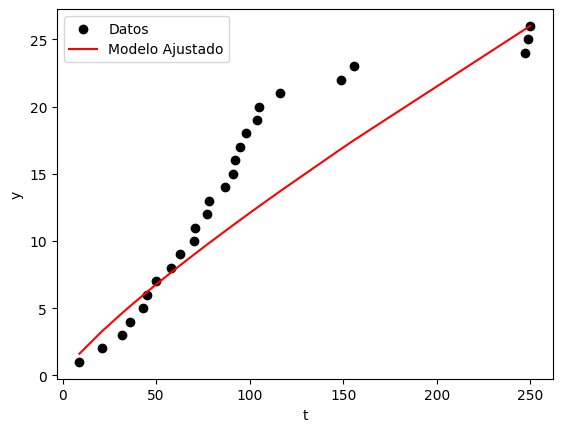

In [3]:
np.random.seed(123)

# Observation period
T = max(cum_days)
n = len(cum_days)

# Define the negative log-likelihood function
def neg_log_likelihood(params):
    a, c = params
    return a * (T**(c+1)) / (c+1) - n * np.log(a) - c * np.sum(np.log(cum_days))  

# Initial guess for parameters
initial_guess = [1.0, 1.0]

# Perform the optimization
result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B')

# Extract the estimated parameters
a_est, c_est = result.x

print(f"Estimated a: {a_est}, mutiplicative term: {a_est/(c_est+1)}")
print(f"Estimated c: {c_est}, power term: {c_est+1}")

# Graficar los datos y el modelo ajustado para visualización
plt.scatter(cum_days, errors, label='Datos', color='black')
plt.plot(cum_days, a_est * cum_days ** (1 + c_est) / (1 + c_est), label='Modelo Ajustado', color='red')
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_prima, c_prima]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 106 seconds.


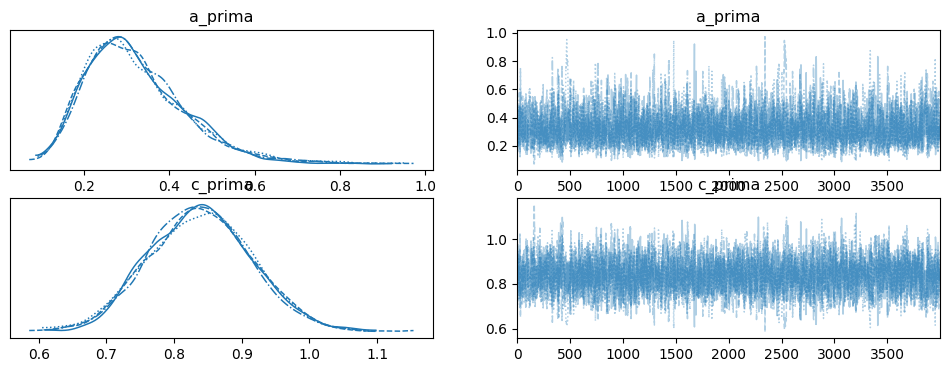

         mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a_prima  0.32  0.12    0.12     0.54        0.0      0.0   2731.43   2928.32   
c_prima  0.84  0.08    0.69     0.98        0.0      0.0   2743.73   2952.25   

         r_hat  
a_prima    1.0  
c_prima    1.0  
Estimación de 'a': 0.322175181222614
Estimación de 'c': 0.8387423907525524


In [5]:
a_prima_est = a_est / (c_est + 1)
c_prima_est = c_est + 1
with pm.Model() as model:    
    a_prima = pm.Gamma('a_prima', alpha=10*a_prima_est**2, beta=10*a_prima_est) 
    c_prima = pm.Gamma('c_prima', alpha=10*c_prima_est**2, beta=10*c_prima_est)
    m_t = a_prima * cum_days ** c_prima

    # a = pm.Exponential('a', lam=a_est)  
    # c = pm.Normal('c', mu=c_est, sigma=0.1)  
    # m_t = a * cum_days ** (c+1)/(c+1)

    observed = pm.Poisson('observed', mu=m_t, observed=errors)
    
    trace = pm.sample(4000, tune=2000, target_accept=0.9, return_inferencedata=True)


# Analizar y visualizar los resultados del muestreo
az.plot_trace(trace)
plt.show()

# Resumen de la distribución posterior
summary = az.summary(trace, round_to=2)
print(summary)

# Extraer los valores medios de 'a' y 'c' de la distribución posterior
a_estimated = trace.posterior["a_prima"].mean().item()
c_estimated = trace.posterior["c_prima"].mean().item()

print("Estimación de 'a':", a_estimated)
print("Estimación de 'c':", c_estimated)

In [3]:
az.plot_pair(trace, divergences=True, kind='kde', marginals=True)

NameError: name 'trace' is not defined

In [37]:
trace = az.from_netcdf('trace.nc')

In [40]:
def sample_random_ac(trace, num_pairs):
    n_samples = trace.posterior.sizes["draw"]  # Número de muestras
    n_chains = trace.posterior.sizes["chain"]  # Número de cadenas

    # Seleccionar aleatoriamente pares de valores
    random_indices = np.random.choice(n_samples * n_chains, num_pairs)  # Índices aleatorios

    chain_indices = random_indices // n_samples  # Índices de la cadena
    draw_indices = random_indices % n_samples  # Índices de la muestra dentro de la cadena

    # Extraer valores de la cadena posterior usando indexación avanzada
    a_values = trace.posterior["a_prima"].values[chain_indices, draw_indices]
    c_values = trace.posterior["c_prima"].values[chain_indices, draw_indices]

    # Combinar los valores a y c en pares
    random_ac = np.column_stack((a_values, c_values))
    return random_ac

In [48]:
def utility_func(x, rho1):
    if rho1 is None: 
        return x
    return (1 - np.exp(-rho1 * x)) / rho1

In [8]:
def compute_expected_utility_vec(t1, p1, lambda1, c11, c21, c31, n, T, ite=5000, rho1=None):    
    # Generating random variables for j=2,3
    ts = uniform.rvs(loc=0, scale=2000, size=(ite, 2))
    ps = uniform.rvs(loc=3000, scale=15000, size=(ite, 2))
    aes = norm.rvs(loc=0.256, scale=0.05, size=(ite, 2))
    aes[aes<0.01] = 0.01
    cs = norm.rvs(loc=0.837, scale=0.05, size=(ite, 2))
    lambda23T = aes * T ** cs
    lambda23t = aes * ts ** cs
    qs = poisson.rvs(lambda23T) - poisson.rvs(lambda23t)
    qs[qs<0.1] = 0

    # Generating buyer random variables
    w = dirichlet.rvs([1, 1, 1], size=ite)
    rho = gamma.rvs(5, scale=1/5, size=ite)

    # Generating random variables for j=1
    e1 = poisson.rvs(lambda1(t1), size=ite)
    eT = poisson.rvs(lambda1(T), size=ite)
    q1 = eT - e1
    q1[q1<0.1] = 0

    # Computing utility
    u1 = 1 - np.exp(-rho * (-w[:, 0] * t1 / T - w[:, 1] * p1 / 5000 - w[:, 2] * q1 / eT))
    u2 = 1 - np.exp(-rho * (-w[:, 0] * ts[:, 0] / T - w[:, 1] * ps[:, 0] / 5000 - w[:, 2] * qs[:, 0] / eT)) - u1
    u3 = 1 - np.exp(-rho * (-w[:, 0] * ts[:, 1] / T - w[:, 1] * ps[:, 1] / 5000 - w[:, 2] * qs[:, 1] / eT)) - u1

    # Computing probability of choice
    pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()
    # Estimating the cost
    c1 = (c11 * t1 + c21 * e1 + c31 * q1).mean()

    # Estimating expected utility
    util = np.sum([comb(n, l) * pi**l * (1 - pi)**(n - l) * utility_func(l * p1 - c1, rho1) for l in range(n+1)])

    return util, pi

In [59]:
def compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=5000, rho1=None):    
    # Generating random variables for j=2,3
    ts = uniform.rvs(loc=0, scale=2000, size=(ite, 2))
    ps = uniform.rvs(loc=3000, scale=15000, size=(ite, 2))
    aes = norm.rvs(loc=0.256, scale=0.05, size=(ite, 2))
    aes[aes<0.01] = 0.01
    cs = norm.rvs(loc=0.837, scale=0.05, size=(ite, 2))
    lambda23T = aes * T ** cs
    lambda23t = aes * ts ** cs
    qs = poisson.rvs(lambda23T) - poisson.rvs(lambda23t)
    qs[qs<0.1] = 0

    # Generating buyer random variables
    w = dirichlet.rvs([1, 1, 1], size=ite)
    rho = gamma.rvs(10, scale=1/10, size=ite)

    # Generating random variables for j=1
    acs = sample_random_ac(trace, ite)
    lambda1_t1 = acs[:, 0] * t1 ** acs[:, 1]
    lambda1_T = acs[:, 0] * T ** acs[:, 1]
    e1 = poisson.rvs(lambda1_t1, size=ite)
    eT = poisson.rvs(lambda1_T, size=ite)
    q1 = eT - e1
    q1[q1<0.1] = 0

    # Computing utility
    u1 = 1 - np.exp(-rho * (-w[:, 0] * t1 / T - w[:, 1] * p1 / 5000 - w[:, 2] * q1 / eT))
    u2 = 1 - np.exp(-rho * (-w[:, 0] * ts[:, 0] / T - w[:, 1] * ps[:, 0] / 5000 - w[:, 2] * qs[:, 0] / eT)) - u1
    u3 = 1 - np.exp(-rho * (-w[:, 0] * ts[:, 1] / T - w[:, 1] * ps[:, 1] / 5000 - w[:, 2] * qs[:, 1] / eT)) - u1

    # Computing probability of choice
    pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()
    # Estimating the cost
    c1 = (c11 * t1 + c21 * e1 + c31 * q1).mean()

    # Estimating expected utility
    util = np.sum([comb(n, l) * pi**l * (1 - pi)**(n - l) * utility_func(l * p1 - c1, rho1) for l in range(n+1)])

    return util, pi

In [72]:
c11 = 0.5
c21 = 1
c31 = 5
n = 1000
T = 2000

# Example usage
t1 = 626
p1 = 10272.72727273
random_ac = []
for i in range(2):
    util, _ = compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=100000)
    random_ac.append(util)

print(random_ac)

[3406616.4419981916, 3416088.7007601783]


In [25]:
c11 = 0.5
c21 = 1
c31 = 5
n = 1000
T = 2000

resultados = np.zeros((100 * 100, 4))
indice = 0
for p1 in np.linspace(3000, 15000, 100):
    for t1 in np.linspace(0, 2000, 100):
        util, prob = compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=10000)
        resultados[indice] = [p1, t1, util, prob]
        indice += 1

indice_mejor = np.argmax(resultados[:, 2])
mejor_datos = resultados[indice_mejor, :2]
mejor_util = resultados[indice_mejor, 2]
mejor_prob = resultados[indice_mejor, 3]

print("Mejores datos:", mejor_datos, "Mejor utilidad:", mejor_util, "Mejor probabilidad:", mejor_prob)
np.save('resultados.npy', resultados)

C:\Users\pgarc\AppData\Local\Temp\ipykernel_1896\3415444743.py:32: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()


Mejores datos: [10151.51515152   929.29292929] Mejor utilidad: 3464304.466521217 Mejor probabilidad: 0.3413558245900615


In [26]:
c11 = 0.5
c21 = 1
c31 = 5
n = 1000
T = 2000

resultados = np.zeros((50 * 50, 4)) 
indice = 0
for p1 in np.linspace(9500, 11000, 50):
    for t1 in np.linspace(500, 1000, 50):
        util, prob = compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=10000)
        resultados[indice] = [p1, t1, util, prob]
        indice += 1

indice_mejor = np.argmax(resultados[:, 2])
mejor_datos = resultados[indice_mejor, :2]
mejor_util = resultados[indice_mejor, 2]
mejor_prob = resultados[indice_mejor, 3]

print("Mejores datos:", mejor_datos, "Mejor utilidad:", mejor_util, "Mejor probabilidad:", mejor_prob)
np.save('resultados_resolucion.npy', resultados)

C:\Users\pgarc\AppData\Local\Temp\ipykernel_1896\3415444743.py:32: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()


Mejores datos: [10234.69387755   551.02040816] Mejor utilidad: 3485064.531083048 Mejor probabilidad: 0.34060415979139613


In [18]:
resultados = np.load('resultados.npy')

In [19]:
indice_mejor = np.argmax(resultados[:, 2])
mejor_datos = resultados[indice_mejor, :2]
mejor_util = resultados[indice_mejor, 2]
mejor_prob = resultados[indice_mejor, 3]

print("Mejores datos:", mejor_datos, "Mejor utilidad:", mejor_util, "Mejor probabilidad:", mejor_prob)

Mejores datos: [10272.72727273   626.26262626] Mejor utilidad: 3394700.898126851 Mejor probabilidad: 0.33055079531541975


In [20]:
mejores_precios = []
for i in range(100):
    seleccion = resultados[abs(resultados[:, 1] - np.linspace(0, 2000, 100)[i]) < 1e-1]    
    mejores_precios.append(seleccion[np.argmax(seleccion[:, 2]), 0])

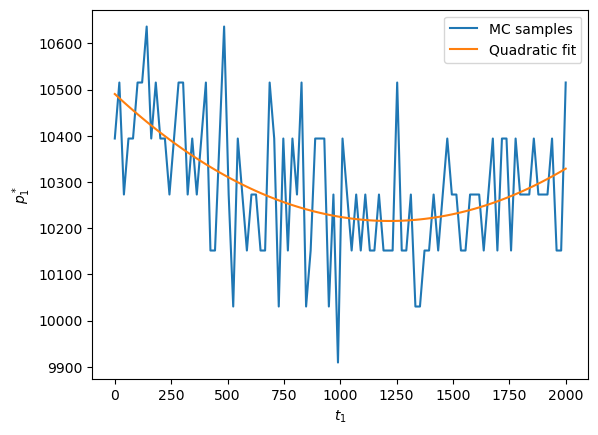

In [25]:
xs = np.linspace(0, 2000, 100)
c, b, a = np.polyfit(xs, mejores_precios, 2)
ys = a + b * xs + c * xs ** 2

plt.plot(xs, mejores_precios)
plt.plot(xs, ys)
plt.xlabel('$t_1$')
plt.ylabel('$p^*_1$')
plt.legend(['MC samples', 'Quadratic fit'])

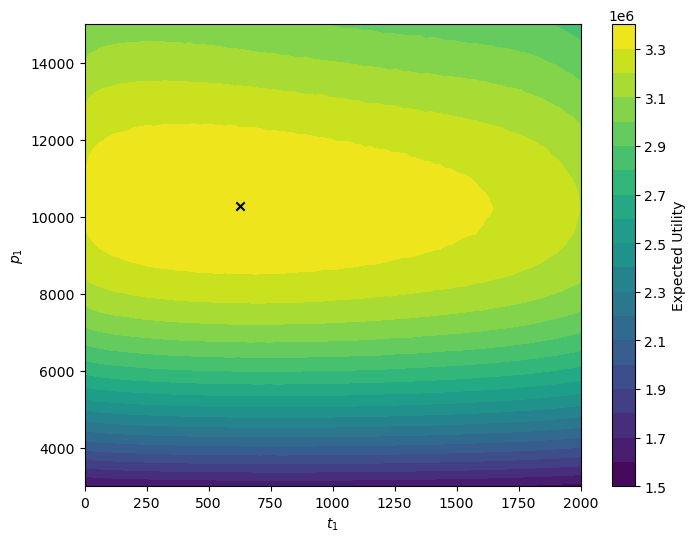

In [13]:
p1_vals = resultados[:, 0]
t1_vals = resultados[:, 1]
util_vals = resultados[:, 2]

p1_unique = np.unique(p1_vals)
t1_unique = np.unique(t1_vals)
util_matrix = util_vals.reshape(len(p1_unique), len(t1_unique))

plt.figure(figsize=(8, 6))
contourf = plt.contourf(t1_unique, p1_unique, util_matrix, levels=20, cmap='viridis')
plt.colorbar(contourf, label='Expected Utility')
plt.scatter(mejor_datos[1], mejor_datos[0], marker='x', c='black')
plt.xlabel('$t_1$')
plt.ylabel('$p_1$')
plt.show()

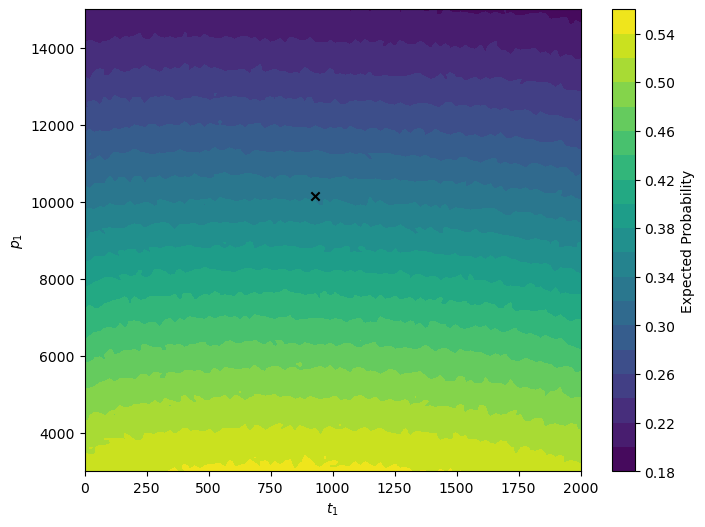

In [34]:
p1_vals = resultados[:, 0]
t1_vals = resultados[:, 1]
prob_vals = resultados[:, 3]

p1_unique = np.unique(p1_vals)
t1_unique = np.unique(t1_vals)
prob_matrix = prob_vals.reshape(len(p1_unique), len(t1_unique))

plt.figure(figsize=(8, 6))
contourf = plt.contourf(t1_unique, p1_unique, prob_matrix, levels=20, cmap='viridis')
plt.colorbar(contourf, label='Expected Probability')
plt.scatter(mejor_datos[1], mejor_datos[0], marker='x', c='black')
plt.xlabel('$t_1$')
plt.ylabel('$p_1$')
plt.show()

C:\Users\pgarc\AppData\Local\Temp\ipykernel_1896\3415444743.py:32: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()


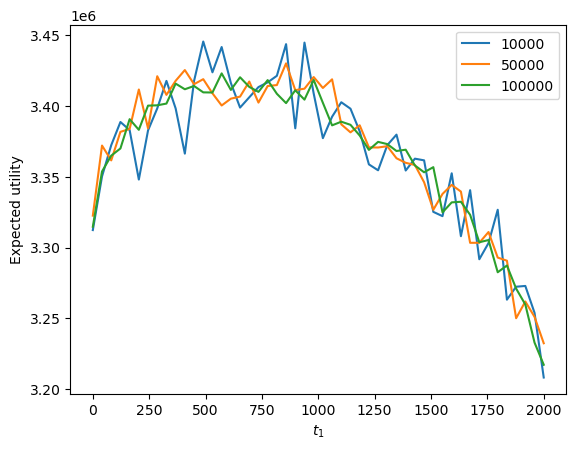

In [28]:
c11 = 0.5
c21 = 1
c31 = 5
n = 1000
T = 2000

utils = []
utils_vec = []
utils_est = []
p1 = 10235
for t1 in np.linspace(0, 2000, 50):
    utils.append(compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=10000))
    utils_vec.append(compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=50000))
    utils_est.append(compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=100000))

plt.plot(np.linspace(0, 2000, 50), [u[0] for u in utils])
plt.plot(np.linspace(0, 2000, 50), [u[0] for u in utils_vec])
plt.plot(np.linspace(0, 2000, 50), [u[0] for u in utils_est])
plt.xlabel('$t_1$')
plt.ylabel('Expected utility')
plt.legend([10000, 50000, 100000])

In [27]:
c11 = 0.5
c21 = 1
c31 = 5
n = 1000
T = 2000

resultados = np.zeros((7 * 20 * 20, 5)) 
indice = 0

rhos = [-1e-6, -1e-7, -1e-8, None, 1e-8, 1e-7, 1e-6]
for rho1 in rhos:
    print(rho1)
    for p1 in np.linspace(9500, 12000, 20):
        for t1 in np.linspace(500, 1000, 20):
            util, prob = compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=10000, rho1=rho1)
            resultados[indice] = [p1, t1, util, prob, rho1]
            indice += 1
np.save('resultados_rhos.npy', resultados)

-1e-06


C:\Users\pgarc\AppData\Local\Temp\ipykernel_1896\3415444743.py:32: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()


-1e-07
-1e-08
None
1e-08
1e-07
1e-06


In [39]:
resultados_rho = np.load('resultados_rho.npy', allow_pickle=True)

rhos = [-1e-6, -1e-7, -1e-8, None, 1e-8, 1e-7, 1e-6]
for rho in rhos:
    if rho is None:
        seleccion = resultados_rho[[r is None for r in resultados_rho[:, 4]]]   
    else:
        seleccion = resultados_rho[resultados_rho[:, 4] == rho]    
    
    indice_mejor = np.argmax(seleccion[:, 2])
    mejor_datos = seleccion[indice_mejor, :2]
    mejor_util = seleccion[indice_mejor, 2]
    mejor_prob = seleccion[indice_mejor, 3]

    print(f"Rho: {rho}, p_1: {mejor_datos[0]:.0f}, t_1: {mejor_datos[1]:.0f}, Mejor utilidad: {mejor_util:.0f}, Mejor probabilidad: {mejor_prob:.2f}")

Rho: -1e-06, p_1: 10265, t_1: 610, Mejor utilidad: 28750104, Mejor probabilidad: 0.33
Rho: -1e-07, p_1: 10265, t_1: 541, Mejor utilidad: 4025621, Mejor probabilidad: 0.33
Rho: -1e-08, p_1: 10429, t_1: 573, Mejor utilidad: 3438592, Mejor probabilidad: 0.32
Rho: None, p_1: 10347, t_1: 602, Mejor utilidad: 3381704, Mejor probabilidad: 0.33
Rho: 1e-08, p_1: 10265, t_1: 696, Mejor utilidad: 3324167, Mejor probabilidad: 0.33
Rho: 1e-07, p_1: 10224, t_1: 561, Mejor utilidad: 2868262, Mejor probabilidad: 0.33
Rho: 1e-06, p_1: 10224, t_1: 578, Mejor utilidad: 965588, Mejor probabilidad: 0.33


In [29]:
resultados_c31 = np.load('resultados_c31.npy', allow_pickle=True)

c31s = np.linspace(1, 20, 40)
df_resultados = pd.DataFrame(columns=['c31', 'p1', 't1', 'util', 'prob'])
for c31 in c31s:
    seleccion = resultados_c31[resultados_c31[:, 4] == c31]    
    indice_mejor = np.argmax(seleccion[:, 2])
    mejor_datos = seleccion[indice_mejor, :2]
    mejor_util = seleccion[indice_mejor, 2]
    mejor_prob = seleccion[indice_mejor, 3]

    new_row = pd.DataFrame([{'c31': c31, 'p1': mejor_datos[0], 't1': mejor_datos[1], 'util': mejor_util, 'prob': mejor_prob}])
    df_resultados = pd.concat([df_resultados, new_row], ignore_index=True)

df_resultados

/tmp/ipykernel_2721756/4234523235.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_resultados = pd.concat([df_resultados, new_row], ignore_index=True)


,c31,p1,t1,util,prob
0,1.000000,10346.938776,548.979592,3.407273e+06,0.329347
1,1.487179,10306.122449,565.306122,3.407629e+06,0.330692
2,1.974359,10265.306122,606.122449,3.406944e+06,0.331947
3,2.461538,10183.673469,524.489796,3.407763e+06,0.334691
4,2.948718,10428.571429,593.877551,3.407360e+06,0.326801
5,3.435897,10387.755102,520.408163,3.407235e+06,0.328076
6,3.923077,10183.673469,622.448980,3.407281e+06,0.334664
7,4.410256,10306.122449,630.612245,3.407083e+06,0.330674
8,4.897436,10551.020408,561.224490,3.406974e+06,0.322992
9,5.384615,10510.204082,577.551020,3.406752e+06,0.324231


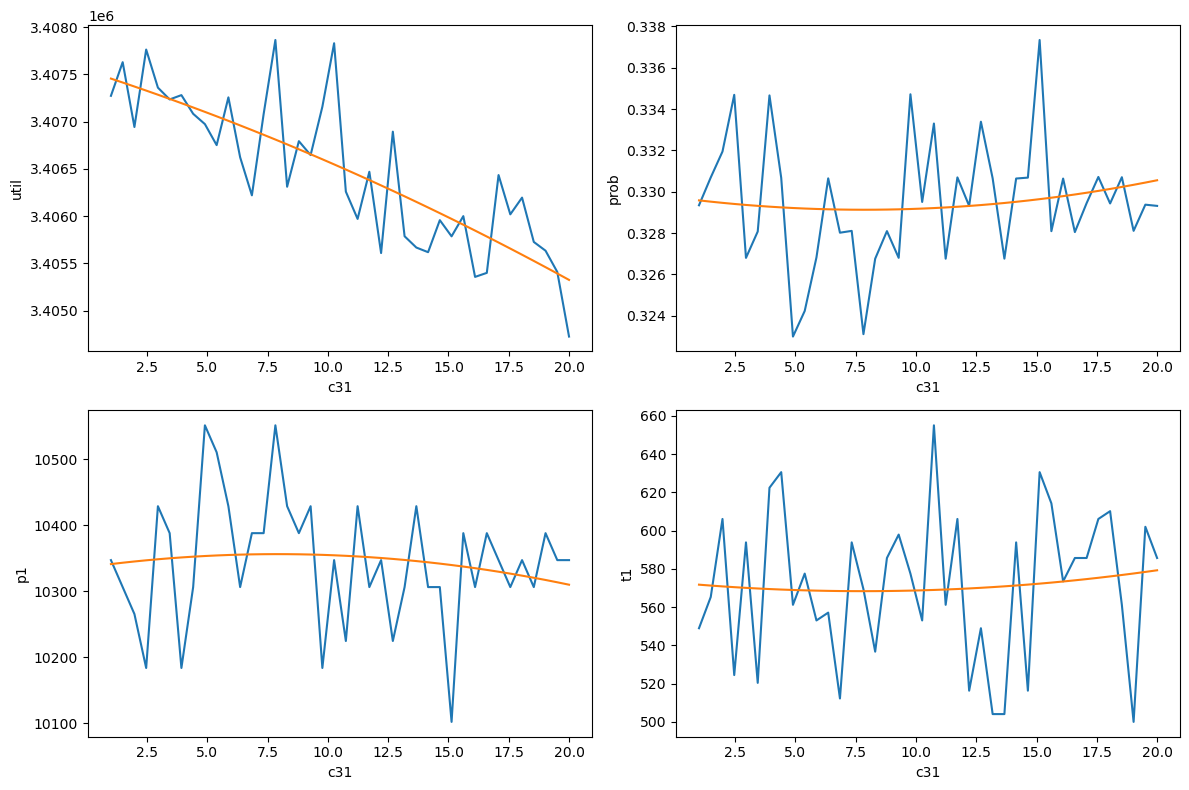

In [34]:
# subplots of util, prob, p1 and t1 against c31
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, var in enumerate(['util', 'prob', 'p1', 't1']):
    axs[i // 2, i % 2].plot(df_resultados['c31'], df_resultados[var])
    # Fit a quadratic polynomial to the data
    c, b, a = np.polyfit(df_resultados['c31'], df_resultados[var], 2)
    var_fit = a + b * df_resultados['c31'] + c * df_resultados['c31'] ** 2
    axs[i // 2, i % 2].plot(df_resultados['c31'], var_fit)
    axs[i // 2, i % 2].set_xlabel('c31')
    axs[i // 2, i % 2].set_ylabel(var)

plt.tight_layout()
plt.show()


In [25]:
from skopt import gp_minimize
from skopt.space import Real
from functools import partial

# Define the parameter space
space = [Real(3000, 15000, name='p1'), Real(0, 2000, name='t1')]
    
c11 = 0.5
c21 = 1
c31 = 5
n = 1000  
T = 2000

# Define the objective function wrapper for skopt
def objective_function(params, c11, c21, c31, n, T):
    p1, t1 = params
    return -compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=100000)[0]

# Define partial function for passing extra parameters to the objective function
objective_function_partial = partial(objective_function, c11=c11, c21=c21, c31=c31, n=n, T=T)

# Perform Bayesian optimization
result = gp_minimize(objective_function_partial, space, n_calls=200)

# Get the optimal parameters
p1_optimal, t1_optimal = result.x
optimal_utility = -result.fun

print("Optimal p1:", p1_optimal)
print("Optimal t1:", t1_optimal)
print("Optimal utility:", optimal_utility)

C:\Users\pgarc\AppData\Local\Temp\ipykernel_22624\1639659771.py:32: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()
C:\Users\pgarc\AppData\Local\Temp\ipykernel_22624\1639659771.py:32: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()
C:\Users\pgarc\AppData\Local\Temp\ipykernel_22624\1639659771.py:32: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()
C:\Users\pgarc\AppData\Local\Temp\ipykernel_22624\1639659771.py:32: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()
C:\Users\pgarc\AppData\Local\Temp\ipykernel_22624\1639659771.py:32: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()
C:\Users\pgarc\AppData\Local\Temp\ipykernel_22624\1639659771.py:32: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()
C:\Users\pgarc\AppData\Local

Optimal p1: 10329.360789384475
Optimal t1: 492.4433431587562
Optimal utility: 3412669.0952434884


In [26]:
c11 = 0.5
c21 = 1
c31 = 5
n = 1000  
T = 2000

def generate_neighbor(t1, p1):
    # Generate a neighboring solution by perturbing t1 and p1 within a certain range
    new_t1 = np.clip(t1 + np.random.uniform(-50, 50), 0, 2000)
    new_p1 = np.clip(p1 + np.random.uniform(-200, 200), 3000, 15000)
    return new_t1, new_p1

def simulated_annealing(initial_t1, initial_p1, c11, c21, c31, n, T, max_iter=1000):
    # Set initial temperature and cooling rate
    temperature = 1000
    cooling_rate = 0.99

    # Initialize current solution
    current_t1, current_p1 = initial_t1, initial_p1
    current_util = compute_expected_utility_vec_random_ac(current_t1, current_p1, c11, c21, c31, n, T, ite=100000)[0]

    # Initialize best solution
    best_t1, best_p1 = current_t1, current_p1
    best_util = current_util

    # Simulated Annealing algorithm
    for _ in tqdm.tqdm(range(max_iter)):
        # Generate a neighboring solution
        new_t1, new_p1 = generate_neighbor(current_t1, current_p1)

        # Calculate the cost of the new solution
        new_util = compute_expected_utility_vec_random_ac(new_t1, new_p1, c11, c21, c31, n, T, ite=100000)[0]

        # Calculate the acceptance probability
        delta_util = new_util - current_util
        acceptance_probability = np.exp(delta_util / temperature)

        # Accept or reject the new solution
        if np.random.uniform() < acceptance_probability:
            current_t1, current_p1 = new_t1, new_p1
            current_util = new_util

        # Update the best solution
        if current_util > best_util:
            best_t1, best_p1 = current_t1, current_p1
            best_util = current_util

        # Cool down the temperature
        temperature *= cooling_rate

    return best_t1, best_p1

# Example usage
initial_t1 = np.random.uniform(0, 2000)
initial_p1 = np.random.uniform(3000, 15000)
best_t1, best_p1 = simulated_annealing(initial_t1, initial_p1, c11, c21, c31, n, T)
print("Best t_1:", best_t1)
print("Best p_1:", best_p1)

C:\Users\pgarc\AppData\Local\Temp\ipykernel_22624\1639659771.py:32: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()
  3%|▎         | 27/1000 [2:16:06<81:45:00, 302.47s/it]


KeyboardInterrupt: 